pip install sentence-transformers==0.3 <br>
https://pypi.org/project/sentence-transformers/


# Sentence-BERT

- Recommend to use for supervised learning
1. Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks <br>
https://arxiv.org/pdf/1908.10084.pdf
2. Making Monolingual Sentence Embeddings Multilingual using
Knowledge Distillation <br>
https://arxiv.org/pdf/2004.09813.pdf

### Sentence-BERT

- Triplet Network의 목적은 기준 데이터로부터 근사한 데이터는 가깝게, 근사하지 않은 데이터는 멀리 떨어뜨려서 적절한 분리 공간에 배치하도록 하는 것이 목적이다. 
- **Triplet Objective Function**
1. Classification Objective Function <br>
- Sentence A와 Sentence B의 임베딩을 concat하고 weight를 곱해서 학습
- softmax확률을 구하고 cross-entropy loss에 따라 학습
2. Regression Objective Function <br>
- 두 문장 사이의 코사인 유사도를 계산하고, mse loss값을 objective function으로 사용한다.
3. Triplet Objective Function <br>
- (anchor, positive, negative)
- triplet loss는 anchor와 positive 사이의 loss가 anchor와 negative 사이의 loss보다 작도록 학습시킨다. 

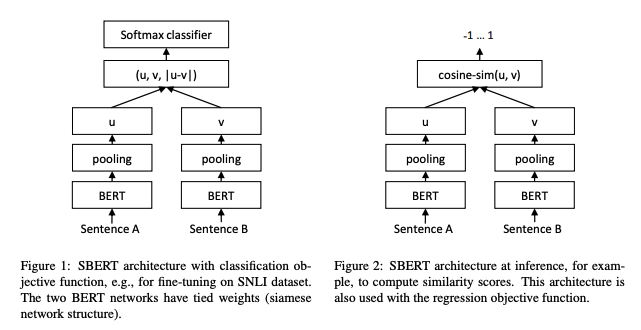

### More on Sentence-BERT

1. Use SBERT as a Teacher Model and USE XLM-RoBERTa as a student model
2. Teacher and Student model can share information and use for knowledge distillation

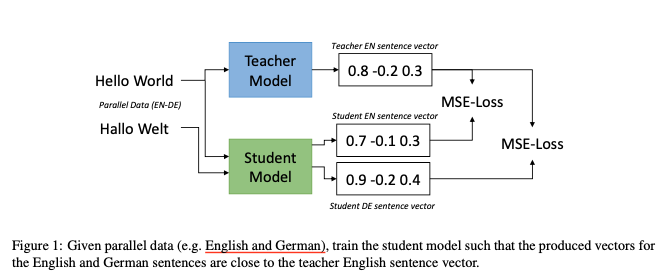

In [ ]:
from sentence_transformers import SentenceTransformer, SentencesDataset, LoggingHandler, losses, models
from torch.utils.data import DataLoader
from sentence_transformers.readers import TripletReader
from sentence_transformers.evaluation import TripletEvaluator
from datetime import datetime
import pandas as pd
import random
import csv

### Define model

In [ ]:
word_embedding_model = models.Transformer('monologg/kobert')

In [ ]:
# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)


In [ ]:
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
batch_size = 64
num_epochs = 1
model_path = 'sbert/'

### Load Dataset

- Convert dataframe to triplet dataset

In [ ]:
def create_triplet_file(tag):
    raw_df = pd.read_csv(f'nsmc/ratings_{tag}.txt', sep='\t')
    raw_df = raw_df.dropna(axis=0)
    raw_df = raw_df.head(int(raw_df.shape[0]*0.005))

    print(raw_df.shape)
    
    grouped = raw_df.groupby('label')['document']
    zero_group = [raw_df['document'].loc[x] for x in list(grouped.groups[0])]
    one_group = [raw_df['document'].loc[x] for x in list(grouped.groups[1])]
    
    output_file = open(f'nsmc/ratings_{tag}_triplet.txt','w',encoding='utf-8')
    for sent in zero_group:
        sent_to_write = "긍정"+"\u241E"+sent+"\u241E"+random.choice(one_group)
        output_file.write(sent_to_write+'\n')

    for sent in one_group:
        sent_to_write = "부정"+"\u241E"+sent+"\u241E"+random.choice(zero_group)
        output_file.write(sent_to_write+'\n')
    output_file.close()

In [ ]:
create_triplet_file('train')

(749, 3)


In [ ]:
create_triplet_file('test')

(249, 3)


In [ ]:
triplet_reader = TripletReader('nsmc', s1_col_idx=0, s2_col_idx=1, s3_col_idx=2, delimiter='\u241E',
                                   quoting=csv.QUOTE_MINIMAL, has_header=True)

In [ ]:
print("Read Triplet train dataset")
train_data = SentencesDataset(examples=triplet_reader.get_examples('ratings_train_triplet.txt'), model=model)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

print("Read Triplet Test dataset")
test_data = SentencesDataset(examples=triplet_reader.get_examples('ratings_test_triplet.txt'), model=model)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

Read Triplet train dataset
Read Triplet Test dataset


### Train SBert model

In [ ]:
train_loss = losses.TripletLoss(model=model)
evaluator = TripletEvaluator(test_dataloader)

#### 참고: Warmup step을 사용하는 이유
- 출처: https://zzaebok.github.io/deep_learning/RAdam/ <br>
![image.png](attachment:image.png)

In [ ]:
warmup_steps = int(len(train_dataloader.dataset) * num_epochs / batch_size*0.1) #10% of train data

In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_path)

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.65s/it]


### Get sbert embedding vectors

In [ ]:
sentence_embedding = model.encode('영화 진짜 재미없다')
print(len(sentence_embedding[0]))

### Evaluate model

In [ ]:
model = SentenceTransformer('sbert')

In [ ]:
model.evaluate(evaluator, output_path='sbert')